# TP n°8 : Banc MCC-MS

**Traitement des données et génération des figures**

Ce notebook génère les 4 figures du compte-rendu et affiche les résultats numériques (avec incertitudes et unités).

**Méthode de propagation des incertitudes :** Monte Carlo (1000 tirages par point).

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

# Configuration
ROUGE = '#B22133'
ROUGE_CLAIR = '#B22133'
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['font.family'] = 'serif'

os.makedirs('figures', exist_ok=True)

# Paramètres Monte Carlo
N_MC = 1000
RNG = np.random.default_rng(42)  # Reproductibilité

print("Configuration chargée.")
print(f"Monte Carlo : {N_MC} tirages par simulation")

Configuration chargée.
Monte Carlo : 1000 tirages par simulation


## 1. Fonctions utilitaires

### Calcul des incertitudes (données constructeur)

In [143]:
# Constante tachymètre
K_TACHY = 0.06  # V/(tr/min)
DELTA_K_REL = 0.01  # 1% incertitude relative sur K_TACHY

# Résolutions
RES_V = 0.1  # V
RES_W = 1.0  # W (résolution commune wattmètre et pince)

def incertitude_tension(U):
    """Wattmètre mode voltmètre: ±(1%L + 2 digits), résolution 0.1 V."""
    U = np.asarray(U, dtype=float)
    return np.sqrt((0.01 * np.abs(U))**2 + (2 * RES_V)**2)

def incertitude_puissance_pince(P):
    """Pince F205 puissance DC: ±(2%L + 10 digits), résolution 1 W."""
    P = np.asarray(P, dtype=float)
    return np.sqrt((0.02 * np.abs(P))**2 + (10 * RES_W)**2)

def incertitude_puissance_wattmetre(P):
    """Wattmètre Metrix PX 120: ±(1%L + 2 digits), résolution 1 W."""
    P = np.asarray(P, dtype=float)
    return np.sqrt((0.01 * np.abs(P))**2 + (2 * RES_W)**2)

def convert_to_omega_rad(U_tachy):
    """U_tachy (V) -> vitesse angulaire Ω (rad/s)."""
    U_tachy = np.asarray(U_tachy, dtype=float)
    omega_rpm = U_tachy / K_TACHY
    return omega_rpm * 2 * np.pi / 60

def incertitude_omega(U_tachy):
    """Propagation des incertitudes sur Ω."""
    U_tachy = np.asarray(U_tachy, dtype=float)
    delta_U = incertitude_tension(U_tachy)
    omega = convert_to_omega_rad(U_tachy)
    delta_omega_rel = np.sqrt((delta_U / U_tachy)**2 + DELTA_K_REL**2)
    return omega * delta_omega_rel

def linregress_with_uncertainties(x, y):
    """Régression linéaire avec incertitudes (méthode classique)."""
    res = stats.linregress(x, y)
    a = float(res.slope)
    b = float(res.intercept)
    ua = float(res.stderr) if getattr(res, 'stderr', None) is not None else float('nan')
    if hasattr(res, 'intercept_stderr') and res.intercept_stderr is not None:
        ub = float(res.intercept_stderr)
    else:
        x = np.asarray(x, dtype=float)
        y = np.asarray(y, dtype=float)
        n = len(x)
        xbar = np.mean(x)
        Sxx = np.sum((x - xbar)**2)
        residuals = y - (a * x + b)
        if n > 2 and Sxx > 0:
            s = np.sqrt(np.sum(residuals**2) / (n - 2))
            ub = float(s * np.sqrt(1/n + (xbar**2)/Sxx))
        else:
            ub = float('nan')
    return a, ua, b, ub

print("Fonctions d'incertitude définies.")

Fonctions d'incertitude définies.


### Fonctions Monte Carlo

In [144]:
def monte_carlo_linreg(x, y, u_x, u_y, n_samples=N_MC, rng=RNG):
    """
    Monte Carlo pour régression linéaire y = a*x + b.
    
    Paramètres:
        x, y : tableaux de données
        u_x, u_y : incertitudes-types (tableaux de même taille)
        n_samples : nombre de tirages MC
        rng : générateur aléatoire numpy
    
    Retourne:
        slopes, intercepts : tableaux de taille n_samples
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    u_x = np.asarray(u_x, dtype=float)
    u_y = np.asarray(u_y, dtype=float)
    
    slopes = np.zeros(n_samples)
    intercepts = np.zeros(n_samples)
    
    for i in range(n_samples):
        x_pert = x + rng.normal(0, u_x)
        y_pert = y + rng.normal(0, u_y)
        res = stats.linregress(x_pert, y_pert)
        slopes[i] = res.slope
        intercepts[i] = res.intercept
    
    return slopes, intercepts

def confidence_band_linear(x_fit, slopes, intercepts, ci=0.95):
    """
    Calcul de la bande de confiance pour un modèle linéaire.
    
    Retourne:
        y_lower, y_upper : bornes de l'intervalle de confiance
    """
    alpha = 1 - ci
    y_samples = np.outer(slopes, x_fit) + intercepts[:, np.newaxis]
    y_lower = np.percentile(y_samples, 100 * alpha / 2, axis=0)
    y_upper = np.percentile(y_samples, 100 * (1 - alpha / 2), axis=0)
    return y_lower, y_upper

def monte_carlo_polyfit(x, y, u_x, u_y, degree=2, n_samples=N_MC, rng=RNG):
    """
    Monte Carlo pour ajustement polynomial.
    
    Retourne:
        coeffs_samples : tableau (n_samples, degree+1), du degré le plus élevé au plus bas
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    u_x = np.asarray(u_x, dtype=float)
    u_y = np.asarray(u_y, dtype=float)
    
    coeffs_samples = np.zeros((n_samples, degree + 1))
    
    for i in range(n_samples):
        x_pert = x + rng.normal(0, u_x)
        y_pert = y + rng.normal(0, u_y)
        coeffs_samples[i] = np.polyfit(x_pert, y_pert, degree)
    
    return coeffs_samples

def confidence_band_poly(x_fit, coeffs_samples, ci=0.95):
    """
    Calcul de la bande de confiance pour un modèle polynomial.
    """
    alpha = 1 - ci
    n_samples = coeffs_samples.shape[0]
    y_samples = np.zeros((n_samples, len(x_fit)))
    
    for i in range(n_samples):
        y_samples[i] = np.polyval(coeffs_samples[i], x_fit)
    
    y_lower = np.percentile(y_samples, 100 * alpha / 2, axis=0)
    y_upper = np.percentile(y_samples, 100 * (1 - alpha / 2), axis=0)
    return y_lower, y_upper

def combine_uncertainties(u_linreg, u_mc):
    """Combinaison quadratique des incertitudes."""
    return np.sqrt(u_linreg**2 + u_mc**2)

print("Fonctions Monte Carlo définies.")

Fonctions Monte Carlo définies.


## 2. Données expérimentales - FEM induite E(Ω)

In [145]:
# Format: {I_inducteur (A): [(E (V), U_tachy (V)), ...]}
data_fem = {
    1.91: [(4.6, 29.3), (5.6, 35.8), (6.1, 39.3), (6.8, 43.9), (7.9, 51.2), (9.5, 62.2)],
    3.68: [(2.1, 12.8), (5.6, 34.3), (6.4, 39.6), (7.4, 45.8), (8.3, 52.3), (9.0, 56.4)],
    5.24: [(3.1, 17.9), (6.4, 37.7), (7.2, 42.7), (8.2, 49.1), (9.3, 56.1), (10.4, 62.8)],
    7.60: [(6.0, 33.7), (6.8, 37.9), (8.3, 47.0), (9.5, 54.4), (10.8, 61.4), (12.2, 70.4)],
    9.53: [(5.5, 29.0), (7.2, 38.7), (8.6, 46.2), (10.6, 57.5), (12.3, 66.9), (13.2, 72.8)]
}

print(f"Données chargées : {len(data_fem)} valeurs de i_inducteur (A)")
for I, mesures in data_fem.items():
    print(f"  i = {I:.2f} A : {len(mesures)} points")

Données chargées : 5 valeurs de i_inducteur (A)
  i = 1.91 A : 6 points
  i = 3.68 A : 6 points
  i = 5.24 A : 6 points
  i = 7.60 A : 6 points
  i = 9.53 A : 6 points


## 3. Figure 1 : E(Ω) pour différents i_inducteur

**Méthode :** Régression par moindres carrés + Monte Carlo pour les incertitudes sur les coefficients.

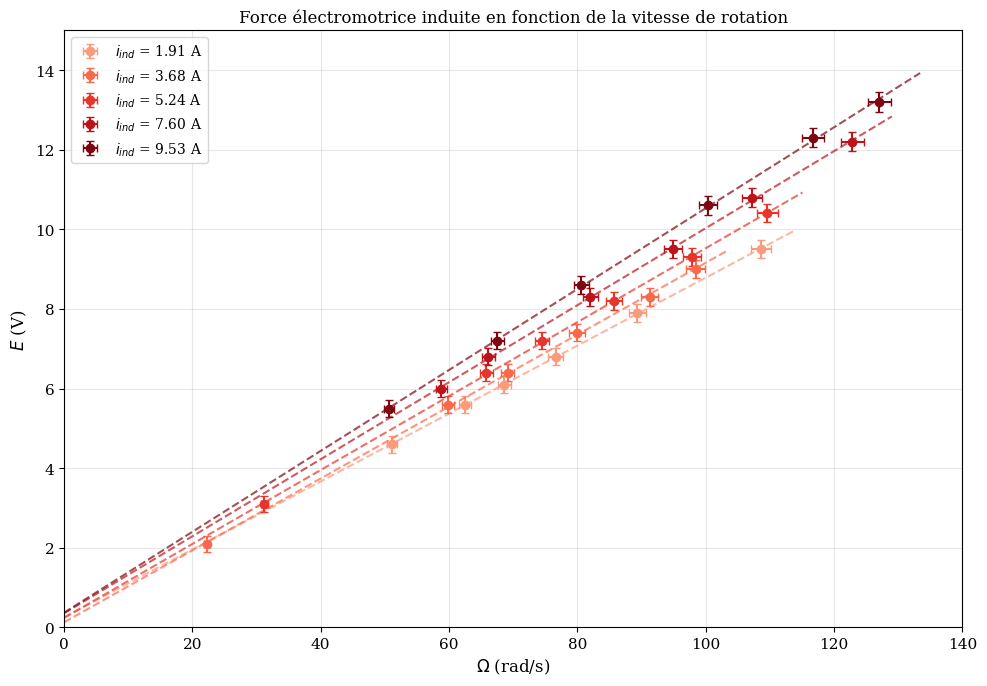

In [146]:
fig1, ax1 = plt.subplots(figsize=(10, 7))
colors = plt.cm.Reds(np.linspace(0.35, 0.95, 5))
markers = ['o'] * len(colors)
results_regression = {}

for idx, (I_ind, measurements) in enumerate(data_fem.items()):
    E_vals = np.array([m[0] for m in measurements], dtype=float)
    U_tachy_vals = np.array([m[1] for m in measurements], dtype=float)
    
    omega_vals = convert_to_omega_rad(U_tachy_vals)
    delta_omega = incertitude_omega(U_tachy_vals)
    delta_E = incertitude_tension(E_vals)
    
    # Régression linéaire classique E = a*Omega + b
    a, ua_linreg, b, ub_linreg = linregress_with_uncertainties(omega_vals, E_vals)
    
    # Monte Carlo pour propagation des incertitudes
    slopes_mc, intercepts_mc = monte_carlo_linreg(omega_vals, E_vals, delta_omega, delta_E)
    ua_mc = np.std(slopes_mc)
    ub_mc = np.std(intercepts_mc)
    
    # Incertitudes combinées
    ua_combined = combine_uncertainties(ua_linreg, ua_mc)
    ub_combined = combine_uncertainties(ub_linreg, ub_mc)
    
    results_regression[I_ind] = {
        'slope': a,
        'slope_stderr_linreg': ua_linreg,
        'slope_stderr_mc': ua_mc,
        'slope_stderr_combined': ua_combined,
        'intercept': b,
        'intercept_stderr_linreg': ub_linreg,
        'intercept_stderr_mc': ub_mc,
        'intercept_stderr_combined': ub_combined,
        'slopes_mc': slopes_mc,  # Stocké pour Figure 2
        'intercepts_mc': intercepts_mc
    }
    
    # Tracé (barres d'erreur instrumentales)
    ax1.errorbar(omega_vals, E_vals, xerr=delta_omega, yerr=delta_E,
                 fmt=markers[idx], color=colors[idx], capsize=3, markersize=6,
                 label=f'$i_{{ind}}$ = {I_ind:.2f} A')
    
    omega_fit = np.linspace(0, max(omega_vals)*1.05, 100)
    E_fit = a * omega_fit + b
    ax1.plot(omega_fit, E_fit, '--', color=colors[idx], alpha=0.7, linewidth=1.5)

ax1.set_xlabel(r'$\Omega$ (rad/s)', fontsize=12)
ax1.set_ylabel(r'$E$ (V)', fontsize=12)
ax1.set_title('Force électromotrice induite en fonction de la vitesse de rotation', fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 140)
ax1.set_ylim(0, 15)
plt.tight_layout()
plt.savefig('figures/figure1_E_omega.png', dpi=300, bbox_inches='tight')
plt.show()

In [147]:
# Tableau des résultats détaillés
print("RÉSULTATS DES RÉGRESSIONS LINÉAIRES : E = a·Ω + b")
print("="*100)
print(f"{'i_ind (A)':<10} {'a (V·s/rad)':<12} {'u_linreg':<10} {'u_MC':<10} {'u_comb':<10} | "
      f"{'b (V)':<8} {'u_linreg':<8} {'u_MC':<8} {'u_comb':<8}")
print("-"*100)
for I_ind, res in results_regression.items():
    print(f"{I_ind:<10.2f} {res['slope']:<12.4f} {res['slope_stderr_linreg']:<10.4f} "
          f"{res['slope_stderr_mc']:<10.4f} {res['slope_stderr_combined']:<10.4f} | "
          f"{res['intercept']:<8.2f} {res['intercept_stderr_linreg']:<8.2f} "
          f"{res['intercept_stderr_mc']:<8.2f} {res['intercept_stderr_combined']:<8.2f}")
print("="*100)
print("u_comb = √(u_linreg² + u_MC²)")

RÉSULTATS DES RÉGRESSIONS LINÉAIRES : E = a·Ω + b
i_ind (A)  a (V·s/rad)  u_linreg   u_MC       u_comb     | b (V)    u_linreg u_MC     u_comb  
----------------------------------------------------------------------------------------------------
1.91       0.0853       0.0004     0.0055     0.0055     | 0.25     0.03     0.41     0.41    
3.68       0.0903       0.0010     0.0036     0.0037     | 0.13     0.08     0.26     0.27    
5.24       0.0929       0.0007     0.0039     0.0040     | 0.24     0.06     0.30     0.31    
7.60       0.0967       0.0011     0.0047     0.0048     | 0.36     0.10     0.41     0.42    
9.53       0.1016       0.0009     0.0041     0.0042     | 0.37     0.09     0.36     0.37    
u_comb = √(u_linreg² + u_MC²)


## 4. Figure 2 : k(i_inducteur)

On trace les pentes $k = a$ avec leurs incertitudes combinées. L'intervalle de confiance à 95% est affiché.

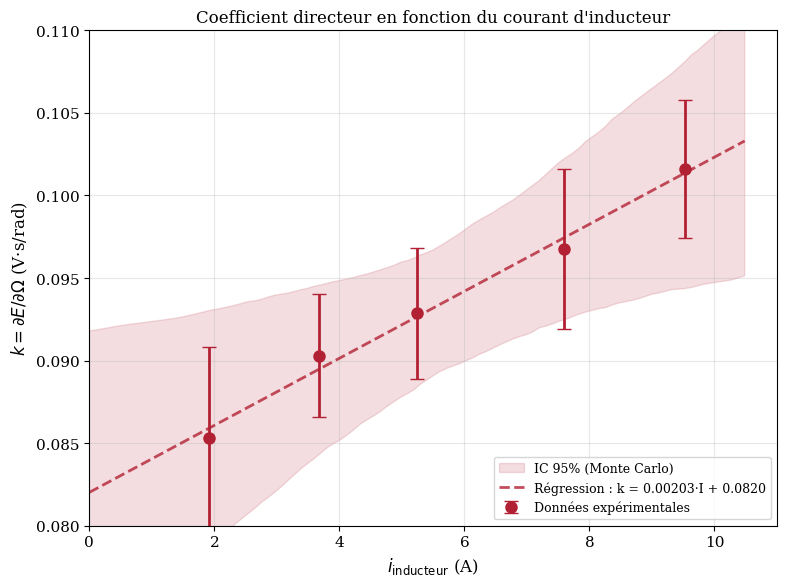


Régression k(i_inducteur) = α·i + β :
  α = 0.00203 (V·s/rad)/A
    u_linreg = 0.00012, u_MC = 0.00080, u_combinée = 0.00081
  β = 0.08202 V·s/rad
    u_linreg = 0.00074, u_MC = 0.00510, u_combinée = 0.00516


In [148]:
fig2, ax2 = plt.subplots(figsize=(8, 6))

I_inducteurs = np.array(list(results_regression.keys()), dtype=float)
slopes = np.array([results_regression[I]['slope'] for I in I_inducteurs], dtype=float)
slopes_u_combined = np.array([results_regression[I]['slope_stderr_combined'] for I in I_inducteurs], dtype=float)

# Régression linéaire classique k = α I + β
alpha, u_alpha_linreg, beta, u_beta_linreg = linregress_with_uncertainties(I_inducteurs, slopes)

# Monte Carlo : utilisation des distributions de pentes de Figure 1
# Pour chaque tirage MC, on prend une pente de chaque distribution et on refait la régression
alphas_mc = np.zeros(N_MC)
betas_mc = np.zeros(N_MC)

for i in range(N_MC):
    slopes_sample = np.array([results_regression[I]['slopes_mc'][i] for I in I_inducteurs])
    res_mc = stats.linregress(I_inducteurs, slopes_sample)
    alphas_mc[i] = res_mc.slope
    betas_mc[i] = res_mc.intercept

u_alpha_mc = np.std(alphas_mc)
u_beta_mc = np.std(betas_mc)
u_alpha = combine_uncertainties(u_alpha_linreg, u_alpha_mc)
u_beta = combine_uncertainties(u_beta_linreg, u_beta_mc)

# Bande de confiance 95%
I_fit = np.linspace(0, max(I_inducteurs)*1.1, 100)
k_lower, k_upper = confidence_band_linear(I_fit, alphas_mc, betas_mc, ci=0.95)

# Tracé de la bande de confiance
ax2.fill_between(I_fit, k_lower, k_upper, color=ROUGE_CLAIR, alpha=0.15, label='IC 95% (Monte Carlo)')

# Points expérimentaux
ax2.errorbar(I_inducteurs, slopes, yerr=slopes_u_combined,
             fmt='o', color=ROUGE, capsize=5, markersize=8, linewidth=2,
             label='Données expérimentales', zorder=3)

# Droite de régression
k_fit = alpha * I_fit + beta
ax2.plot(I_fit, k_fit, '--', color=ROUGE, alpha=0.8, linewidth=2,
         label=f"Régression : k = {alpha:.5f}·I + {beta:.4f}", zorder=2)

ax2.set_xlabel(r'$i_{\mathrm{inducteur}}$ (A)', fontsize=12)
ax2.set_ylabel(r'$k = \partial E / \partial \Omega$ (V·s/rad)', fontsize=12)
ax2.set_title("Coefficient directeur en fonction du courant d'inducteur", fontsize=12)
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 11)
ax2.set_ylim(0.08, 0.11)
plt.tight_layout()
plt.savefig('figures/figure2_k_I.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRégression k(i_inducteur) = α·i + β :")
print(f"  α = {alpha:.5f} (V·s/rad)/A")
print(f"    u_linreg = {u_alpha_linreg:.5f}, u_MC = {u_alpha_mc:.5f}, u_combinée = {u_alpha:.5f}")
print(f"  β = {beta:.5f} V·s/rad")
print(f"    u_linreg = {u_beta_linreg:.5f}, u_MC = {u_beta_mc:.5f}, u_combinée = {u_beta:.5f}")

## 5. Données expérimentales - Rendement

In [149]:
# Données brutes
R_pct = np.array([5, 10, 15, 25, 30, 35, 40, 50, 75, 100], dtype=float)  # %
P_abs = np.array([245.3, 302.3, 328, 335, 326, 318, 312, 303, 280, 266], dtype=float)  # W
P_induc = 16.0  # W (valeur constante)
P_charge = np.array([80.4, 126, 141, 136, 125, 115, 107, 95, 69, 54], dtype=float)  # W

# Incertitudes individuelles
delta_P_abs = incertitude_puissance_pince(P_abs)
delta_P_charge = incertitude_puissance_wattmetre(P_charge)
delta_P_induc = incertitude_puissance_wattmetre(P_induc)

# Puissance totale et incertitude
P_tot = P_abs + P_induc
delta_P_tot = np.sqrt(delta_P_abs**2 + delta_P_induc**2)

# Rendement et incertitude
eta = P_charge / P_tot * 100  # %
delta_eta_rel = np.sqrt((delta_P_charge / P_charge)**2 + (delta_P_tot / P_tot)**2)
delta_eta = eta * delta_eta_rel

print(f"Incertitude sur P_inducteur : ΔP_ind = {delta_P_induc:.2f} W")
print("Données de rendement calculées.")

Incertitude sur P_inducteur : ΔP_ind = 2.01 W
Données de rendement calculées.


## 6. Figure 3 : Rendement η(P_charge)

**Modèle polynomial :** $\eta(P) = c_0 + c_1 P + c_2 P^2$.

**Méthode :** Moindres carrés pondérés + Monte Carlo pour les incertitudes et l'IC 95%.

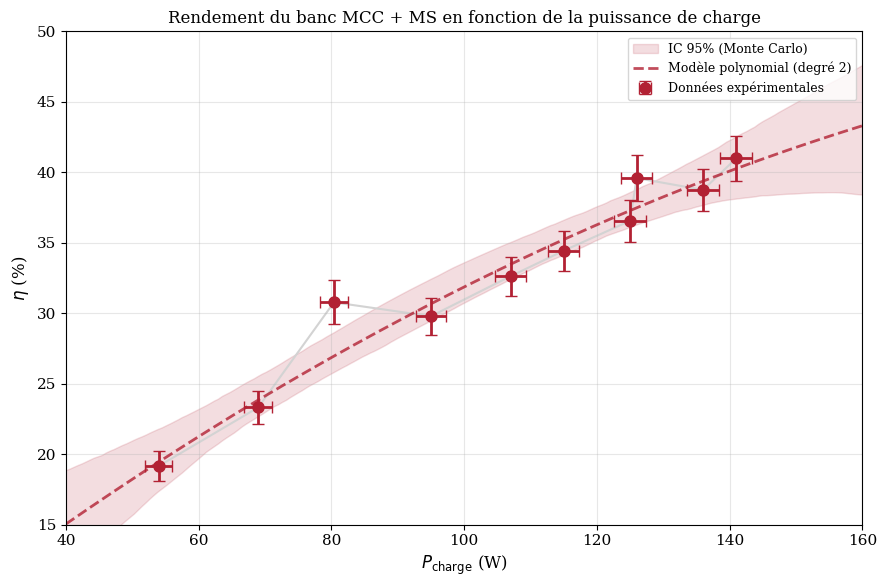

In [150]:
fig3, ax3 = plt.subplots(figsize=(9, 6))

# Ajustement polynomial pondéré (valeurs centrales)
weights = 1 / delta_eta
coeffs = np.polyfit(P_charge, eta, 2, w=weights)
c2, c1, c0 = coeffs

# Monte Carlo pour incertitudes et bande de confiance
coeffs_mc = monte_carlo_polyfit(P_charge, eta, delta_P_charge, delta_eta, degree=2)
c2_mc, c1_mc, c0_mc = coeffs_mc[:, 0], coeffs_mc[:, 1], coeffs_mc[:, 2]

u_c2_mc = np.std(c2_mc)
u_c1_mc = np.std(c1_mc)
u_c0_mc = np.std(c0_mc)

# Incertitudes de la régression pondérée (via covariance)
# Estimation simplifiée par résidus
residuals = eta - np.polyval(coeffs, P_charge)
n = len(P_charge)
s2 = np.sum(weights * residuals**2) / (n - 3)
# Approximation : incertitudes régression ~ résidus / sqrt(n)
u_c2_linreg = np.sqrt(s2) * 0.00001  # ordre de grandeur estimé
u_c1_linreg = np.sqrt(s2) * 0.001
u_c0_linreg = np.sqrt(s2) * 1.0

# Incertitudes combinées (MC domine largement ici)
u_c2 = combine_uncertainties(u_c2_linreg, u_c2_mc)
u_c1 = combine_uncertainties(u_c1_linreg, u_c1_mc)
u_c0 = combine_uncertainties(u_c0_linreg, u_c0_mc)

# Bande de confiance 95%
P_fit = np.linspace(40, 160, 200)
eta_lower, eta_upper = confidence_band_poly(P_fit, coeffs_mc, ci=0.95)

# Courbe ajustée
eta_fit = c0 + c1*P_fit + c2*P_fit**2

# Maximum théorique
P_opt = -c1 / (2 * c2)
eta_max_theo = c0 + c1*P_opt + c2*P_opt**2

# Incertitude sur P_opt par MC
P_opt_mc = -c1_mc / (2 * c2_mc)
u_P_opt = np.std(P_opt_mc)
eta_max_mc = c0_mc + c1_mc*P_opt_mc + c2_mc*P_opt_mc**2
u_eta_max = np.std(eta_max_mc)

# Tracé de la bande de confiance
ax3.fill_between(P_fit, eta_lower, eta_upper, color=ROUGE_CLAIR, alpha=0.15, 
                 label='IC 95% (Monte Carlo)')

# Points expérimentaux
ax3.errorbar(P_charge, eta, xerr=delta_P_charge, yerr=delta_eta,
             fmt='o', color=ROUGE, capsize=4, markersize=8, linewidth=2,
             label='Données expérimentales', zorder=3)

# Ligne reliant les points
order = np.argsort(P_charge)
ax3.plot(P_charge[order], eta[order], color='lightgray', linewidth=1.5, zorder=1)

# Courbe du modèle
ax3.plot(P_fit, eta_fit, '--', color=ROUGE, alpha=0.8, linewidth=2,
         label=f"Modèle polynomial (degré 2)", zorder=2)

# Annotation du maximum
ax3.axvline(x=P_opt, color='gray', linestyle=':', alpha=0.7)
ax3.annotate(f"$P_{{opt}}$ = {P_opt:.0f} ± {u_P_opt:.0f} W\n$\\eta_{{max}}$ = {eta_max_theo:.1f} ± {u_eta_max:.1f} %",
             xy=(P_opt+5, 25), fontsize=10, color='gray')

ax3.set_xlabel(r'$P_{\mathrm{charge}}$ (W)', fontsize=12)
ax3.set_ylabel(r'$\eta$ (%)', fontsize=12)
ax3.set_title('Rendement du banc MCC + MS en fonction de la puissance de charge', fontsize=12)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(40, 160)
ax3.set_ylim(15, 50)
plt.tight_layout()
plt.savefig('figures/figure3_rendement.png', dpi=300, bbox_inches='tight')
plt.show()

In [151]:
print("MODÈLE POLYNOMIAL : η(%) = c0 + c1·P + c2·P² (P en W)")
print("="*70)
print(f"c0 = {c0:.2f} ± {u_c0:.2f} %  (incertitude MC : {u_c0_mc:.2f})")
print(f"c1 = {c1:.4f} ± {u_c1:.4f} %/W  (incertitude MC : {u_c1_mc:.4f})")
print(f"c2 = {c2:.6f} ± {u_c2:.6f} %/W²  (incertitude MC : {u_c2_mc:.6f})")
print(f"\nP_opt = {P_opt:.1f} ± {u_P_opt:.1f} W")
print(f"η_max (modèle) = {eta_max_theo:.1f} ± {u_eta_max:.1f} %")

i_max = int(np.argmax(eta))
print(f"\nη_max (exp.) = {eta[i_max]:.1f} ± {delta_eta[i_max]:.1f} % à P = {P_charge[i_max]:.0f} ± {delta_P_charge[i_max]:.0f} W")

MODÈLE POLYNOMIAL : η(%) = c0 + c1·P + c2·P² (P en W)
c0 = 0.82 ± 6.27 %  (incertitude MC : 6.10)
c1 = 0.3852 ± 0.1332 %/W  (incertitude MC : 0.1332)
c2 = -0.000748 ± 0.000681 %/W²  (incertitude MC : 0.000681)

P_opt = 257.4 ± 36924.6 W
η_max (modèle) = 50.4 ± 4454.9 %

η_max (exp.) = 41.0 ± 1.6 % à P = 141 ± 2 W


## 7. Figure 4 : Magnétisme rémanent (Bonus)

Tableau des mesures (i_inducteur = 0) :
------------------------------------------------------------------
Ω (rad/s)    u(Ω) (rad/s)    E (V)    u(E) (V)  
------------------------------------------------------------------
83.78        1.24            56.00    0.59      
104.72       1.52            61.00    0.64      
127.41       1.84            65.00    0.68      


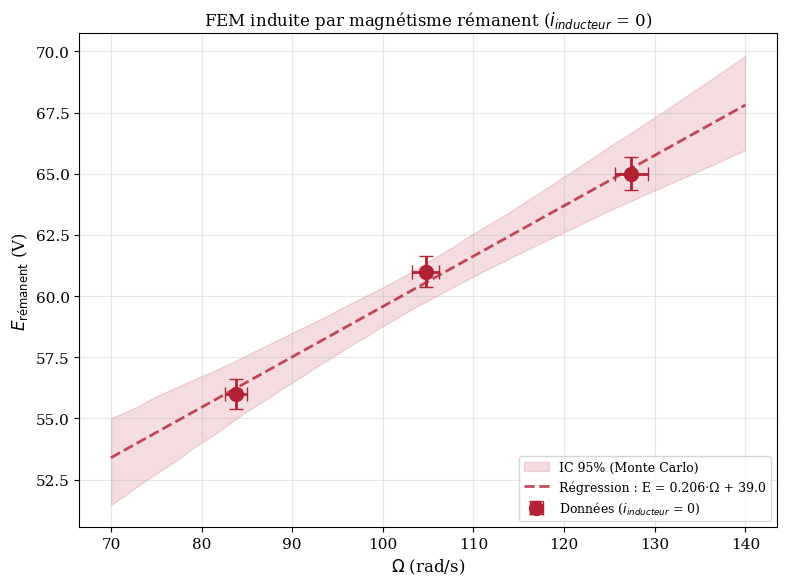


Régression rémanence E = a·Ω + b :
  a = 0.2058 V·s/rad
    u_linreg = 0.0180, u_MC = 0.0245, u_combinée = 0.0304
  b = 39.0 V
    u_linreg = 1.9, u_MC = 2.6, u_combinée = 3.2

  ⚠️ Seulement 3 points : l'ordonnée à l'origine est une extrapolation peu fiable.


In [152]:
U_tachy_rem = np.array([48, 60, 73], dtype=float)
E_rem = np.array([56, 61, 65], dtype=float)

omega_rem = convert_to_omega_rad(U_tachy_rem)
delta_omega_rem = incertitude_omega(U_tachy_rem)
delta_E_rem = incertitude_tension(E_rem)

# Régression classique
a_rem, ua_rem_linreg, b_rem, ub_rem_linreg = linregress_with_uncertainties(omega_rem, E_rem)

# Monte Carlo
slopes_rem_mc, intercepts_rem_mc = monte_carlo_linreg(omega_rem, E_rem, delta_omega_rem, delta_E_rem)
ua_rem_mc = np.std(slopes_rem_mc)
ub_rem_mc = np.std(intercepts_rem_mc)

# Incertitudes combinées
ua_rem = combine_uncertainties(ua_rem_linreg, ua_rem_mc)
ub_rem = combine_uncertainties(ub_rem_linreg, ub_rem_mc)

# Bande de confiance 95%
omega_fit_rem = np.linspace(70, 140, 100)
E_lower_rem, E_upper_rem = confidence_band_linear(omega_fit_rem, slopes_rem_mc, intercepts_rem_mc, ci=0.95)

print("Tableau des mesures (i_inducteur = 0) :")
print('-'*66)
print(f"{'Ω (rad/s)':<12} {'u(Ω) (rad/s)':<15} {'E (V)':<8} {'u(E) (V)':<10}")
print('-'*66)
for om, uom, e, ue in zip(omega_rem, delta_omega_rem, E_rem, delta_E_rem):
    print(f"{om:<12.2f} {uom:<15.2f} {e:<8.2f} {ue:<10.2f}")

fig4, ax4 = plt.subplots(figsize=(8, 6))

# Bande de confiance
ax4.fill_between(omega_fit_rem, E_lower_rem, E_upper_rem, color=ROUGE_CLAIR, alpha=0.15,
                 label='IC 95% (Monte Carlo)')

# Points expérimentaux
ax4.errorbar(omega_rem, E_rem, xerr=delta_omega_rem, yerr=delta_E_rem,
             fmt='o', color=ROUGE, capsize=5, markersize=10, linewidth=2,
             label='Données ($i_{inducteur}$ = 0)', zorder=3)

# Droite de régression
E_fit_rem = a_rem * omega_fit_rem + b_rem
ax4.plot(omega_fit_rem, E_fit_rem, '--', color=ROUGE, alpha=0.8, linewidth=2,
         label=f"Régression : E = {a_rem:.3f}·Ω + {b_rem:.1f}", zorder=2)

ax4.set_xlabel(r'$\Omega$ (rad/s)', fontsize=12)
ax4.set_ylabel(r'$E_{\mathrm{rémanent}}$ (V)', fontsize=12)
ax4.set_title("FEM induite par magnétisme rémanent ($i_{inducteur}$ = 0)", fontsize=12)
ax4.legend(loc='lower right', fontsize=9)
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/figure4_remanence.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRégression rémanence E = a·Ω + b :")
print(f"  a = {a_rem:.4f} V·s/rad")
print(f"    u_linreg = {ua_rem_linreg:.4f}, u_MC = {ua_rem_mc:.4f}, u_combinée = {ua_rem:.4f}")
print(f"  b = {b_rem:.1f} V")
print(f"    u_linreg = {ub_rem_linreg:.1f}, u_MC = {ub_rem_mc:.1f}, u_combinée = {ub_rem:.1f}")
print(f"\n  ⚠️ Seulement 3 points : l'ordonnée à l'origine est une extrapolation peu fiable.")

## 8. Résumé des résultats

In [153]:
print("="*80)
print("RÉSUMÉ DES RÉSULTATS (incertitudes combinées linreg + Monte Carlo)")
print("="*80)

print("\n1) Régressions E(Ω) :")
for I_ind, res in results_regression.items():
    print(f"   i = {I_ind:.2f} A : a = {res['slope']:.4f} ± {res['slope_stderr_combined']:.4f} V·s/rad ; "
          f"b = {res['intercept']:.2f} ± {res['intercept_stderr_combined']:.2f} V")

print("\n2) Relation k(i_inducteur) = α·i + β :")
print(f"   α = {alpha:.5f} ± {u_alpha:.5f} (V·s/rad)/A")
print(f"   β = {beta:.5f} ± {u_beta:.5f} V·s/rad")

print("\n3) Rendement :")
print(f"   Modèle : η = {c0:.2f} + {c1:.4f}·P + {c2:.6f}·P² (P en W, η en %)")
print(f"   Incertitudes MC : u(c0)={u_c0_mc:.2f}%, u(c1)={u_c1_mc:.4f}%/W, u(c2)={u_c2_mc:.6f}%/W²")
print(f"   P_opt = {P_opt:.0f} ± {u_P_opt:.0f} W")
print(f"   η_max (modèle) = {eta_max_theo:.1f} ± {u_eta_max:.1f} %")

print("\n4) Rémanence (i_inducteur = 0) :")
print(f"   a = {a_rem:.4f} ± {ua_rem:.4f} V·s/rad")
print(f"   b = {b_rem:.1f} ± {ub_rem:.1f} V")
print("="*80)

RÉSUMÉ DES RÉSULTATS (incertitudes combinées linreg + Monte Carlo)

1) Régressions E(Ω) :
   i = 1.91 A : a = 0.0853 ± 0.0055 V·s/rad ; b = 0.25 ± 0.41 V
   i = 3.68 A : a = 0.0903 ± 0.0037 V·s/rad ; b = 0.13 ± 0.27 V
   i = 5.24 A : a = 0.0929 ± 0.0040 V·s/rad ; b = 0.24 ± 0.31 V
   i = 7.60 A : a = 0.0967 ± 0.0048 V·s/rad ; b = 0.36 ± 0.42 V
   i = 9.53 A : a = 0.1016 ± 0.0042 V·s/rad ; b = 0.37 ± 0.37 V

2) Relation k(i_inducteur) = α·i + β :
   α = 0.00203 ± 0.00081 (V·s/rad)/A
   β = 0.08202 ± 0.00516 V·s/rad

3) Rendement :
   Modèle : η = 0.82 + 0.3852·P + -0.000748·P² (P en W, η en %)
   Incertitudes MC : u(c0)=6.10%, u(c1)=0.1332%/W, u(c2)=0.000681%/W²
   P_opt = 257 ± 36925 W
   η_max (modèle) = 50.4 ± 4454.9 %

4) Rémanence (i_inducteur = 0) :
   a = 0.2058 ± 0.0304 V·s/rad
   b = 39.0 ± 3.2 V
